# Brain Tumor Classification with ResNet

## Data Preparation

In [51]:
# import libraries

import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, makedirs
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
import torch
from torch import nn

In [52]:
def crop_imgs(img_set, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in img_set:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


In [53]:
!unzip tumor_dataset.zip

Archive:  tumor_dataset.zip
replace no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [54]:
def augment(img_set, dest_dir, num_replication):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest')

    for img in img_set:
        img = img.reshape((1,) + img.shape)
        count = 0
        for batch in data_gen.flow(x=img, batch_size=1, save_to_dir=dest_dir, save_format='jpg'):
            count += 1
            if count > num_replication:
                break

In [55]:
def plot_img(img, title=""):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title(title)

In [56]:
def read_imgs(file_dir):
    img_set = []
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        img_set.append(image)
    return img_set    

In [57]:
yes_img_set = read_imgs('yes')
no_img_set = read_imgs('no')

In [58]:
print("pos data count: ", len(yes_img_set))
print("neg data count: ", len(no_img_set))

pos data count:  155
neg data count:  98


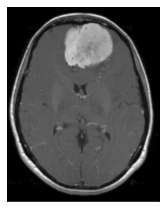

In [59]:
plot_img(yes_img_set[22])

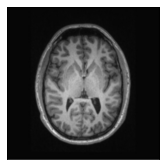

In [60]:
plot_img(no_img_set[2])

In [61]:
yes_img_set_cropped = crop_imgs(yes_img_set)
no_img_set_cropped = crop_imgs(no_img_set)

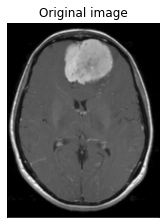

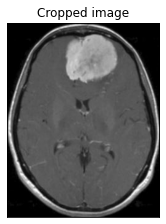

In [62]:
plot_img(yes_img_set[22], "Original image")
plot_img(yes_img_set_cropped[22], "Cropped image")

In [63]:
try:
    makedirs('augmented/yes')
    makedirs('augmented/no')
except:
    pass    

In [64]:
augment(yes_img_set_cropped, 'augmented/yes', 7)
augment(no_img_set_cropped, 'augmented/no', 8)

KeyboardInterrupt: ignored

In [ ]:
num_yes = len(listdir('augmented/yes'))
num_no = len(listdir('augmented/no'))
    
print("Dataset Size:" , num_yes + num_no)
print("Positive samples num:", num_yes, ", Percentage:", num_yes/(num_yes + num_no) * 100)
print("Negative samples num:", num_no, ", Percentage:", num_no/(num_yes + num_no) * 100)

In [ ]:
def load_data_to_tensor(data_dir):
    X = 
    len(listdir(data_dir + '/yes'))
    y = []

    for directory in dir_list:
        print(directory)
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = image / 255
            X.append(image)
            target = int(directory.contains('yes'))
            y.append(target)
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
load_data_to_tensor('augmented')

## Model

In [96]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, k, s, bn_flag, dp_flag):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding = (k-s+2)//2, bias=True)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=k, stride=s, padding = (k-s+2)//2, bias=True)
        self.bn_flag = bn_flag
        self.dp_flag = dp_flag
        if bn_flag:
            self.batch_norm =  nn.BatchNorm2d(out_c)
        if dp_flag:
            self.drop_out =  nn.Dropout(p = 0.3)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if in_c != out_c:
            self.downsample = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=1, stride=s, padding=(1-s+2)//2, bias=True))


    def forward(self, x):
        o = self.conv1(x)
        if self.bn_flag:
            o = self.batch_norm(o)
        o = self.relu(o)
        if self.dp_flag:
            o = self.drop_out(o)
        o = self.conv2(o)
        if self.bn_flag:
            o = self.batch_norm(o)
        o = self.relu(o)
        if self.dp_flag:
            o = self.drop_out(o)
        o += self.downsample(x)
        return o

In [97]:
class ResNet(nn.Module):
    def __init__(self, num_classes, bn_flag, dp_flag):
        super(ResNet, self).__init__()
        self.block1 = ResidualBlock(in_c=1, out_c=8, k=7, s=2, bn_flag=bn_flag, dp_flag=dp_flag)
        self.block2 = ResidualBlock(in_c=8, out_c=16, k=5, s=2, bn_flag=bn_flag, dp_flag=dp_flag)
        self.block3 = ResidualBlock(in_c=16, out_c=32, k=3, s=2, bn_flag=bn_flag, dp_flag=dp_flag)
        self.fc = nn.Linear(100, num_classes, bias=True)
        self.softmax = nn.Softmax()


    def forward(self, x):
        o = self.block1(x)   
        o = self.block2(o)   
        o = self.block3(o)   
        o = self.fc(o)
        o = self.softmax(o)
        return o

In [98]:
model = ResNet(2, True, True)

In [85]:
print(model)

ResNet(
  (block1): ResidualBlock(
    (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv2): Conv2d(8, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout(p=0.3, inplace=False)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout(p=0.3, inplace=False)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stri

## Classification


### Loss and Accuracy Plots

## Furthur investigation


### Batch Normalization

### Dropout

### Visualization